In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/

import pickle
from tqdm import tqdm
import os
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from scipy.sparse import hstack
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RandomizedSearchCV
import math
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score , accuracy_score



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data=pd.read_csv('/content/drive/MyDrive/DT on donors choose/preprocessed_data.csv')

In [4]:
y=data['project_is_approved']
X=data.drop(['project_is_approved'], axis=1)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)

In [7]:
vectorizer_essay=TfidfVectorizer(ngram_range=(1,4), min_df=10, max_features=5000)
vectorizer_essay.fit(X_train['essay'].values)

TfidfVectorizer(max_features=5000, min_df=10, ngram_range=(1, 4))

In [8]:
X_train_bow_essay= vectorizer_essay.transform(tqdm(X_train['essay'].values))
#X_cv_bow_essay=vectorizer.transform(tqdm(X_cv['essay'].values))
X_test_bow_essay=vectorizer_essay.transform(tqdm(X_test['essay'].values))

100%|██████████| 36052/36052 [00:23<00:00, 1512.75it/s]


# featurizing numerical, categorical features

In [9]:
vectorizer_school_state= CountVectorizer()
vectorizer_school_state.fit(X_train['school_state'].values) # fit has to happen only on train data


CountVectorizer()

In [10]:
X_train_state_ohe = vectorizer_school_state.transform(tqdm(X_train['school_state'].values))
#X_cv_state_ohe = vectorizer.transform(tqdm(X_cv['school_state'].values))
X_test_state_ohe = vectorizer_school_state.transform(tqdm(X_test['school_state'].values))

100%|██████████| 36052/36052 [00:00<00:00, 272335.72it/s]


------------

In [11]:
vectorizer_teacher_prefix=CountVectorizer()
vectorizer_teacher_prefix.fit(X_train['teacher_prefix'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector




CountVectorizer()

In [12]:
X_train_teacher_ohe = vectorizer_teacher_prefix.transform(tqdm(X_train['teacher_prefix'].values))
#X_cv_teacher_ohe = vectorizer.transform(tqdm(X_cv['teacher_prefix'].values))
X_test_teacher_ohe = vectorizer_teacher_prefix.transform(tqdm(X_test['teacher_prefix'].values))

100%|██████████| 36052/36052 [00:00<00:00, 259238.07it/s]


----------

In [13]:
vectorizer_project_grade_category = CountVectorizer()
vectorizer_project_grade_category.fit(X_train['project_grade_category'].values)

CountVectorizer()

In [14]:
X_train_grade_ohe = vectorizer_project_grade_category.transform(tqdm(X_train['project_grade_category'].values))
#X_cv_grade_ohe = vectorizer.transform(tqdm(X_cv['project_grade_category'].values))
X_test_grade_ohe = vectorizer_project_grade_category.transform(tqdm(X_test['project_grade_category'].values))

100%|██████████| 36052/36052 [00:00<00:00, 245620.07it/s]


------------------------

In [15]:
vectorizer_clean_categories = CountVectorizer()
vectorizer_clean_categories.fit(X_train['clean_categories'].values)

CountVectorizer()

In [16]:
X_train_clean_categories_ohe = vectorizer_clean_categories.transform(tqdm(X_train['clean_categories'].values))
#X_cv_clean_categories_ohe = vectorizer.transform(tqdm(X_cv['clean_categories'].values))
X_test_clean_categories_ohe = vectorizer_clean_categories.transform(tqdm(X_test['clean_categories'].values))


100%|██████████| 36052/36052 [00:00<00:00, 233133.65it/s]


In [17]:
vectorizer_clean_sub =CountVectorizer()
vectorizer_clean_sub.fit(X_train['clean_subcategories'].values)

CountVectorizer()

In [18]:
X_train_clean_subcategories_ohe = vectorizer_clean_sub.transform(tqdm(X_train['clean_subcategories'].values))
#X_cv_clean_subcategories_ohe = vectorizer.transform(tqdm(X_cv['clean_subcategories'].values))
X_test_clean_subcategories_ohe = vectorizer_clean_sub.transform(tqdm(X_test['clean_subcategories'].values))


100%|██████████| 36052/36052 [00:00<00:00, 227081.40it/s]


In [19]:

normalizer_teacher_number= Normalizer(norm='l1')
normalizer_teacher_number.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))


Normalizer(norm='l1')

In [20]:
X_train_previous_posted_norm = normalizer_teacher_number.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
#X_cv_previous_posted_norm = normalizer.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_previous_posted_norm = normalizer_teacher_number.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

In [21]:
normalizer_price= Normalizer(norm='l1')
normalizer_price.fit(X_train['price'].values.reshape(-1,1))

Normalizer(norm='l1')

In [22]:
X_train_price_norm = normalizer_price.transform(X_train['price'].values.reshape(-1,1))
#X_cv_price_norm = normalizer.transform(X_cv['price'].values.reshape(-1,1))
X_test_price_norm = normalizer_price.transform(X_test['price'].values.reshape(-1,1))


In [23]:
X_tr=hstack((X_train_state_ohe,X_train_teacher_ohe,X_train_grade_ohe, X_train_previous_posted_norm, 
             X_train_clean_categories_ohe,X_train_clean_subcategories_ohe, X_train_bow_essay,X_train_price_norm
            )).tocsr()


#X_crossv=hstack((X_cv_state_ohe,X_cv_teacher_ohe,X_cv_grade_ohe,X_cv_previous_posted_norm,
            # X_cv_clean_categories_ohe, X_cv_clean_subcategories_ohe, X_cv_bow_essay,X_cv_price_norm
           # )).tocsr()


X_te=hstack((X_test_state_ohe,X_test_teacher_ohe,X_test_grade_ohe,X_test_previous_posted_norm,
              X_test_clean_categories_ohe,X_test_clean_subcategories_ohe,X_test_bow_essay,X_test_price_norm
              )).tocsr()

In [24]:
print(X_tr.shape, y_train.shape)
#print(X_crossv.shape, y_cv.shape)
print(X_te.shape,y_test.shape)

(73196, 5101) (73196,)
(36052, 5101) (36052,)


# <h2>1.5 Appling NB on different kind of featurization as mentioned in the instructions</h2>

<br>Apply NB on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

In [25]:
classifier= MultinomialNB(fit_prior=False, class_prior=[0.5,0.5])
parameters={ 
    'class_prior':[[0.1,0.9],[0.2,0.8],[0.3,0.7],[0.4,0.6],[0.5,0.5],[0.6,0.4]],
    'alpha':[0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]}

clf= RandomizedSearchCV(classifier,parameters,cv=10,scoring='roc_auc', return_train_score=True, n_jobs=-1)
clf.fit(X_tr,y_train)

RandomizedSearchCV(cv=10,
                   estimator=MultinomialNB(class_prior=[0.5, 0.5],
                                           fit_prior=False),
                   n_jobs=-1,
                   param_distributions={'alpha': [1e-05, 0.0005, 0.0001, 0.005,
                                                  0.001, 0.05, 0.01, 0.1, 0.5,
                                                  1, 5, 10, 50, 100],
                                        'class_prior': [[0.1, 0.9], [0.2, 0.8],
                                                        [0.3, 0.7], [0.4, 0.6],
                                                        [0.5, 0.5],
                                                        [0.6, 0.4]]},
                   return_train_score=True, scoring='roc_auc')

In [26]:
clf.best_params_

{'alpha': 0.0005, 'class_prior': [0.2, 0.8]}

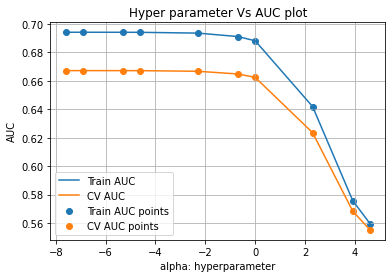

In [27]:

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_alpha'])

train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
alpha =  results['param_alpha']
log=[]
for i in alpha:
    loga=math.log(i)
    log.append(loga)
    
    
    
plt.plot(log, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(log, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(log, train_auc, label='Train AUC points')
plt.scatter(log, cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid()
plt.show()


--------------

# Training model using Best Hyperparmeter

In [58]:
Classifier=MultinomialNB(alpha=0.0005,fit_prior=False, class_prior=[0.2,0.8])
Classifier.fit(X_tr, y_train)


MultinomialNB(alpha=0.0005, class_prior=[0.2, 0.8], fit_prior=False)

In [59]:
y_train_pred=Classifier.predict_proba(X_tr)[:,1]
y_test_pred=Classifier.predict_proba(X_te)[:,1]

In [60]:
y_train_pred.shape

(73196,)

In [61]:
y_train.shape

(73196,)

---

# ROC curve of both train and test data

In [62]:

train_fpr, train_tpr, tr_threshold= roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_threshold = roc_curve(y_test, y_test_pred)

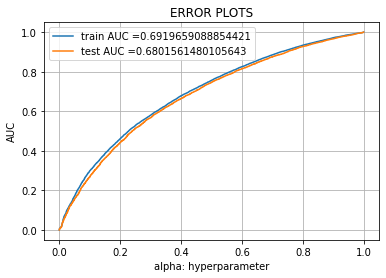

In [63]:
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [64]:
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [65]:
best_t=find_best_threshold(tr_threshold, train_fpr, train_tpr)

the maximum value of tpr*(1-fpr) 0.4104655815873151 for threshold 0.797


In [66]:
cm_train=confusion_matrix(y_train,predict_with_best_t(y_train_pred, best_t))


In [67]:
cm_train

array([[ 7093,  3990],
       [22276, 39837]])

In [68]:
cm_test=confusion_matrix(y_test, predict_with_best_t(y_test_pred,best_t))

In [69]:
cm_test

array([[ 3421,  2038],
       [11012, 19581]])

In [70]:
def confusion_matrix_train_data(cm):
    ax= plt.subplot();
    sns.heatmap(cm,annot=True,cmap='Blues',ax=ax);
    
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_ylim(2.0, 0)
    ax.set_title('Confusion Matrix Train Data');
    ax.xaxis.set_ticklabels(['No','Yes']); 
    ax.yaxis.set_ticklabels(['No','Yes']);

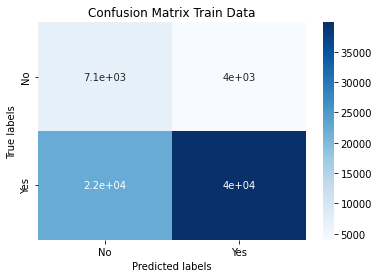

In [71]:
confusion_matrix_train_data(cm_train)

In [72]:
def confusion_matrix_test_data(cm):
    ax= plt.subplot();
    sns.heatmap(cm,annot=True,cmap='Blues',ax=ax);
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_ylim(2.0, 0)
    ax.set_title('Confusion Matrix Test Data');
    ax.xaxis.set_ticklabels(['No','Yes']); 
    ax.yaxis.set_ticklabels(['No','Yes']);

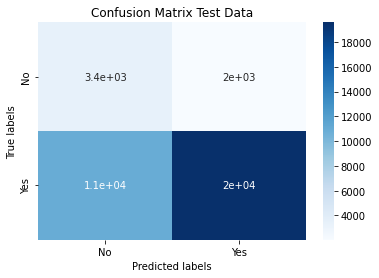

In [73]:
confusion_matrix_test_data(cm_test)


------------

# Finding Top 20 positive and Negative Features

In [74]:
label_0=Classifier.feature_log_prob_[0]


In [75]:
label_1=Classifier.feature_log_prob_[1]

In [76]:
label_1.shape

(5101,)

In [77]:
feature_names = []

In [78]:
#for cnt in vectorizer_clean_categories.get_feature_names():
feature_names.extend(vectorizer_clean_categories.get_feature_names())
    
#for cnt1 in vectorizer_clean_sub.get_feature_names():
feature_names.extend(vectorizer_clean_sub.get_feature_names())

#for cnt2 in vectorizer_essay.get_feature_names():
feature_names.extend(vectorizer_essay.get_feature_names())
    
#for cnt3 in vectorizer_project_grade_category.get_feature_names():
feature_names.extend(vectorizer_project_grade_category.get_feature_names())

#for cnt4 in vectorizer_school_state.get_feature_names():
feature_names.extend(vectorizer_school_state.get_feature_names())
    
#for cnt5 in vectorizer_teacher_prefix.get_feature_names():
feature_names.extend(vectorizer_teacher_prefix.get_feature_names())


In [79]:
feature_names.append('Price')

feature_names.append('prev_proposed_projects')

In [80]:
negative_labels=np.argsort(-label_0)

In [81]:
negative_labels.shape

(5101,)

In [82]:
positive_labels=np.argsort(-label_1)

In [83]:
def top_20_positive_features(feature_list):
    for i in positive_labels[:20]:
        
        print(feature_names[i])
    

In [84]:
top_20_positive_features(feature_names)

prev_proposed_projects
2016
16
21st century learners
20
21st century learning
17
19
45
4th 5th
4th
1st
literacy_language
21st
5th grade
22
students deserve
2017
1st grade
24


In [85]:
def top_20_negative_features(feature_list):
    for i in negative_labels[:20]:
        print(feature_names[i])
    
    

In [86]:

top_20_negative_features(feature_names)

prev_proposed_projects
2016
16
21st century learners
20
21st century learning
17
19
45
4th 5th
4th
1st
22
5th grade
21st
literacy_language
2017
students deserve
24
1st grade


In [87]:
from prettytable import PrettyTable

#If you get a ModuleNotFoundError error , install prettytable using: pip3 install prettytable

x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Alpha:Hyper Parameter",'class_prior', " Test AUC"]

x.add_row(["BOW", "Multonomial Naive Bayes", 0.0005,[0.3,0.7], 0.69])
x.add_row(["TFIDF", "Multinomial Naive Bayes", 0.001,[0.3,0.7], 0.66])

print(x)

+------------+-------------------------+-----------------------+-------------+-----------+
| Vectorizer |          Model          | Alpha:Hyper Parameter | class_prior |  Test AUC |
+------------+-------------------------+-----------------------+-------------+-----------+
|    BOW     | Multonomial Naive Bayes |         0.0005        |  [0.3, 0.7] |    0.69   |
|   TFIDF    | Multinomial Naive Bayes |         0.001         |  [0.3, 0.7] |    0.66   |
+------------+-------------------------+-----------------------+-------------+-----------+
